In [1]:
from ngsolve import *
from ngsolve.webgui import Draw
from netgen.occ import *
from netgen.csg import *
import numpy as np
import matplotlib.pyplot as plt
e0 =  8.854e-12

# 2D

In [2]:
outer = Rectangle(10, 10).Face()
outer = outer.Move((-5,-5,0))
outer.edges.Max(X).name = "r"
outer.edges.Min(X).name = "l"
outer.edges.Min(Y).name = "b"
outer.edges.Max(Y).name = "t"


electrode = Rectangle(0.8, 0.1).Face()

electrode_a = electrode.Move((-0.4, 0.3, 0))
electrode_a.edges.name="inner_upper"
electrode_a.faces.col=(0,0,1)

electrode_b = electrode.Move((-0.4, -0.4, 0))
electrode_b.edges.name="inner_lower"
electrode_b.faces.col=(0,0,1)

face = outer - electrode_a - electrode_b

geo = Glue([outer, electrode_a, electrode_b])




# Draw(geo)

In [3]:
Draw(geo)

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'ngsolve_version': 'Netgen x.x', 'mesh_dim': …

BaseWebGuiScene

In [8]:
def my_2D_simulation(geo, maxh, order):
    mesh = Mesh(OCCGeometry(geo, dim=2).GenerateMesh(maxh=maxh))
    fes = H1(mesh, order =order, dirichlet="inner_lower|inner_upper")
    u, v = fes.TnT()
    gfu = GridFunction(fes)
    bdry_values = {'inner_lower': -1, 'inner_upper': 1}
    gfu.Set(mesh.BoundaryCF(bdry_values, default=0), BND)
    a = BilinearForm(fes)
    a += grad(u)*grad(v)*dx
    a.Assemble()
    r = - a.mat * gfu.vec
    gfu.vec.data += a.mat.Inverse(freedofs=fes.FreeDofs()) * r
    E = -grad(gfu)
    return gfu, E, mesh

def calc_energy(E, mesh):
    energy_density = 0.5*e0*InnerProduct(E,E)
    energy = Integrate(energy_density, mesh)
    return energy


In [9]:
sol, elecrtic_field, mesh = my_2D_simulation(geo, 0.5, 1)

In [10]:
Draw(sol, mesh)

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene

In [13]:
Draw(sol, mesh)

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene

In [6]:
calc_energy(elecrtic_field, mesh)

5.038148276416199e-11

In [47]:
from itertools import product

In [48]:
H = [0.5/(i+1) for i in range(4)]
orders = range(1,4)

energies = np.zeros((len(H), len(orders)))

In [49]:
for i in range(len(H)):
    for j in range(len(orders)):
        E, mesh = my_2D_simulation(geo, H[i], orders[j] )
        energies[i, j] = calc_energy(E, mesh)
        

        

In [50]:
best_result = energies[-1, -1]

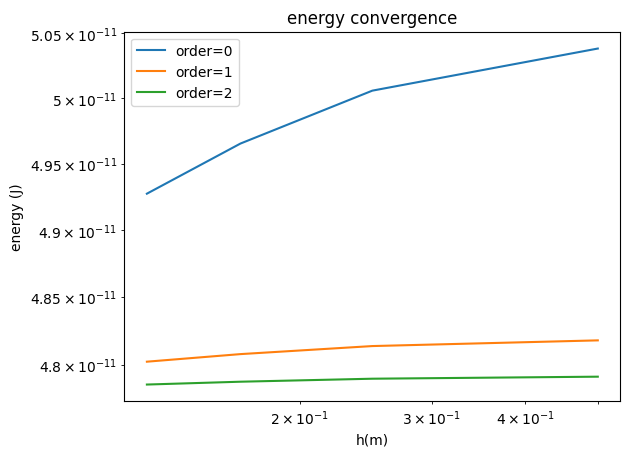

In [51]:
fig, ax = plt.subplots(1,1)
for order in range(0,3):
    ax.loglog(H, energies[:, order], label = f"order={order}")

ax.set(title = "energy convergence", 
       xlabel = "h(m)", 
       ylabel = "energy (J)"
       )
ax.legend()
ax.grid()

From the formula of energy (integral), the only parameter that is not adjusted when going from m->mm is the dielectric constant. For that reason the only difference we expect is that the energy becomes 1000 times smaller. 

# 3D

In [52]:
from ngsolve import *
from ngsolve.webgui import Draw
from netgen.occ import *
from netgen.csg import *
e0 =  8.854e-12

In [53]:
outer = Rectangle(10, 10).Face().Extrude(10)
outer = outer.Move((-5,-5,-5))

for face in outer.faces[:]:
    face.name = "outer"


electrode = Rectangle(0.8, 0.1).Face().Extrude(0.8)

electrode_a = electrode.Move((-0.4, 0.3, 0))
electrode_b = electrode.Move((-0.4, -0.4, 0))

for face_e1, face_e2 in zip(electrode_a.faces[:], electrode_b.faces[:]):
    face_e1.name="e1"
    face_e2.name="e2"


geo = outer - electrode_a - electrode_b

mesh = Mesh(OCCGeometry(geo, dim=3).GenerateMesh(maxh=0.5))

# Draw(mesh, clipping={"y":1, "z":0, "dist":0.0, "function":True})

In [54]:
for edge1, edge2 in zip(electrode_a.edges[:], electrode_b.edges[:]):
    edge1.maxh=0.1
    edge2.maxh=0.1

In [55]:

cf = mesh.BoundaryCF({"e1":1, "e2":-1}, default=0)

fes = H1(mesh, order =1, dirichlet="e1|e2")
u, v = fes.TnT()

a = BilinearForm(e0* grad(u)*grad(v)*dx)
# a +=
a.Assemble()

f = LinearForm(fes).Assemble()
gfu = GridFunction(fes)
gfu.Set(cf, definedon = ".*")

inv = a.mat.Inverse(freedofs=fes.FreeDofs())

r = f.vec - a.mat * gfu.vec

In [56]:
gfu.vec.data += inv * r

In [57]:
E_el = 0.5*e0* Integrate(grad(gfu)**2, mesh)

In [58]:
E_el

0.0

In [59]:
# Defining Dimensions

from ngsolve import *
from ngsolve.webgui import Draw
from netgen.occ import *
from netgen.csg import *
e0 =  8.854e-12




cube = Rectangle(10, 10).Face().Extrude(10).Move((-5,-5,-5))
electrode = Rectangle(0.8, 0.1).Face().Extrude(0.8)
electrode1_sol = electrode.Move((-0.4, 0.3, -0.4))
electrode2_sol = electrode.Move((-0.4, -0.4, -0.4))



for face_e1, face_e2 in zip(electrode1_sol.faces[:], electrode2_sol.faces[:]):
    face_e1.name = "e1"
    face_e2.name = "e2" 

# Merge solids
# solid = cube - electrode1_sol - electrode2_sol

solid = Glue([cube, electrode1_sol, electrode2_sol])
# Apply local mesh size to edges of electrodes
for edge1, edge2 in zip(electrode1_sol.edges[:], electrode2_sol.edges[:]):
    edge1.maxh = 0.05
    edge2.maxh = 0.05

# with TaskManager():
mesh = Mesh(OCCGeometry(solid, dim=3).GenerateMesh(maxh=0.5, grading=0.99))
Draw(mesh)

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene

In [60]:
cf = mesh.BoundaryCF({"e1": 1, "e2": -1}, default = 0)
fes = H1(mesh, order=1, dirichlet="e.*")
u,v = fes.TnT()
# Bilinear form
a = BilinearForm(e0 * grad(u) * grad(v) * dx)
a.Assemble()
# Linear form
# f = LinearForm(fes)
# f.Assemble();
gfu = GridFunction(fes) # solution
# Set Dirichlet BC
gfu.Set(cf, definedon=mesh.Boundaries('.*'))
# Slove System of Linear Equations
inv = a.mat.Inverse(freedofs=fes.FreeDofs())
residuum = - a.mat * gfu.vec
gfu.vec.data += inv * residuum

# Compute Electric energy
E_el = 1/2 * e0 * Integrate(grad(gfu)**2, mesh)
print(E_el)


# cf = mesh.BoundaryCF({"e1":1, "e2":-1}, default=0)

# fes = H1(mesh, order =1, dirichlet="e1|e2")
# u, v = fes.TnT()

# a = BilinearForm(e0* grad(u)*grad(v)*dx)
# a.Assemble()

# f = LinearForm(fes).Assemble()
# gfu = GridFunction(fes)
# gfu.Set(cf, definedon = mesh.Boundaries(".*"))

# inv = a.mat.Inverse(freedofs=fes.FreeDofs())

# r = f.vec - a.mat * gfu.vec

8.070556147016591e-11
